# Deprecated

## Contents
* Predict CNN using time to next event

## Reason
* Might revisit as it has some interesting ideas
* Poor performace
* Time to next event might not be the best y

# Predict interval boundaries on kss audio

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa
import matplotlib.pyplot as plt
import matplotlib.font_manager as mfm


font_path = '/Users/dev/Fonts/Noto_Sans_KR/NotoSansKR-Regular.otf'
k_prop = mfm.FontProperties(fname=font_path)
plt.style.use('dark_background')



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


## Data Preparation
Create features


## Audio Info

Informational:
* Consonant Phonemes duration 25-50 msec
* Vowel Phonemes duration 50-100+ msec


## Character and Syllable Chunk Markers

In [2]:
chunk_dir = 'data/korean-single-speaker/kss_chunks'

chunk_char_df = pd.read_csv(f'{chunk_dir}/chunk_char.csv')
chunk_syl_df = pd.read_csv(f'{chunk_dir}/chunk_syl.csv')


## Event Marker Analysis

### Event Marker Statistics

In [3]:
chunk_char_df['ivl'] = chunk_char_df['stop'] - chunk_char_df['start']
display(chunk_char_df[['ivl', 'start', 'stop']].describe())

# median interval may be used for feature audio length
feat_audio_len_s = chunk_char_df['ivl'].median()
print(f'Feature Audio Length: {feat_audio_len_s}')

,ivl,start,stop
count,133.000000,133.000000,133.000000
mean,0.086957,1.417308,1.504264
std,0.061730,0.998314,1.009050
min,0.006800,0.000000,0.042620
25%,0.044530,0.592430,0.706540
50%,0.073060,1.213770,1.279210
75%,0.113300,2.197060,2.284610
max,0.312600,3.713270,3.972180


Feature Audio Length: 0.07306000000000035


## Event Marker Data

Dictionary of audio_file -> list of event marker times.


In [4]:
char_event_dict = {}
syl_event_dict = {}
audio_files_char = chunk_char_df['audio'].unique()
audio_files_syl = chunk_syl_df['audio'].unique()
audio_files = np.unique(np.concatenate((audio_files_char, audio_files_syl)))

# Warning: The audio file duration is from the 'stop' time of the last event.
# This isn't really guaranteed to be the duration, but it avoids having to load the audio file.
for audio_file in audio_files:
    # Get all start events except for the first one (which is the start of the file)
    char_events = chunk_char_df[chunk_char_df['audio'] == audio_file]['start'].values[1:]
    syl_events = chunk_syl_df[chunk_syl_df['audio'] == audio_file]['start'].values[1:]
    dur = chunk_char_df[chunk_char_df['audio'] == audio_file]['stop'].values[-1]
    char_event_dict[audio_file] = { 'dur': dur, 'events': char_events }
    syl_event_dict[audio_file] = { 'dur': dur, 'events': syl_events }

print(char_event_dict)
print(syl_event_dict)

{'data/korean-single-speaker/kss/1/1_0000.wav': {'dur': 3.52653, 'events': array([0.14298, 0.17326, 0.25143, 0.3011 , 0.39456, 0.49473, 0.52397,
       0.5717 , 0.66385, 0.71846, 0.73074, 0.7928 , 0.86105, 0.8947 ,
       0.94568, 0.98747, 1.00429, 1.05658, 1.12825, 1.20548, 1.24674,
       1.27921, 1.33187, 1.35667, 1.50828, 1.54819, 1.5778 , 1.73609,
       2.04869, 2.15518, 2.28461, 2.3443 , 2.37857, 2.45163, 2.53042,
       2.55297, 2.61609, 2.63233, 2.68239, 2.7029 , 2.76329, 2.86374,
       2.8825 , 2.95272, 3.14772, 3.1583 , 3.4173 ])}, 'data/korean-single-speaker/kss/1/1_0001.wav': {'dur': 3.97218, 'events': array([0.0927 , 0.12765, 0.17218, 0.2192 , 0.2473 , 0.41173, 0.50644,
       0.57461, 0.59243, 0.64042, 0.70654, 0.81835, 0.83326, 0.95153,
       1.09444, 1.11834, 1.20856, 1.37623, 1.59665, 1.64288, 1.76991,
       1.89271, 1.99178, 2.06911, 2.15357, 2.19706, 2.26984, 2.40939,
       2.50919, 2.78858, 2.85241, 2.89864, 2.99798, 3.0465 , 3.09567,
       3.16021, 3.20729, 3

## Audio Data

* Create timestamps with equivalent intervals and "cover" the full audio file with those intervals
 (later the audio file will be padded as needed)
* Find the event closest to the midpoint of those intervals
  * if there is no event, that interval's event value is NaN
  * else event value = (midpoint - event)

DF

i_start, i_stop, i_midpoint, event_offset, audio_dur, audio

In [173]:
window_size_s = 0.5
# window_stride_s = 0.005

In [44]:
def find_nearest_event(t, event_list):
    event_dists = abs(event_list - t)
    nearest_event_idx = np.argmin(event_dists)
    return event_list[nearest_event_idx]

def a_round(val):
    return round(val, 6) if isinstance(val, float) else val

def create_audio_df(event_dict, filenames):
    df_dict = {
        'i_start': [],
        'i_stop': [],
        'i_midpoint': [],
        'nearest_event': [],
        'audio_dur': [],
        'audio': []
    }
    for fn in filenames:
        dur = event_dict[fn]['dur']
        ptr = 0.0

        while ptr < dur:
            w_start = ptr
            w_stop = ptr + window_size_s
            w_midpoint = w_start + (w_stop - w_start)/2

            nearest = find_nearest_event(w_midpoint, event_dict[audio_file]['events'])
            # offset = nearest - w_midpoint
            # offset_is_in_window = abs(offset) > window_size_s / 2
            # event_offset_val = offset if offset_is_in_window  else None

            df_dict['i_start'].append(a_round(w_start))
            df_dict['i_stop'].append(a_round(w_stop))
            df_dict['i_midpoint'].append(a_round(w_midpoint))
            df_dict['nearest_event'].append(a_round(nearest))
            # df_dict['event_offset'].append(a_round(event_offset_val))
            df_dict['audio_dur'].append(dur)
            df_dict['audio'].append(fn)

            ptr = a_round(ptr + window_stride_s)

    audio_df = pd.DataFrame.from_dict(df_dict)
    audio_df['evt_dist'] = audio_df['nearest_event'] - audio_df['i_midpoint']
    audio_df['valid_event'] = audio_df['evt_dist'].abs() < (window_size_s / 2)
    return audio_df

audio_char_df = create_audio_df(char_event_dict, audio_files)
print(audio_char_df['valid_event'].value_counts())
display(audio_char_df)
print('----')
audio_syl_df = create_audio_df(syl_event_dict, audio_files)
print(audio_syl_df['valid_event'].value_counts())
display(audio_syl_df)

True     1214
False    1101
Name: valid_event, dtype: int64
----
False    1451
True      864
Name: valid_event, dtype: int64


,i_start,i_stop,i_midpoint,nearest_event,audio_dur,audio,evt_dist,valid_event
0,0.000,0.100,0.050,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.03071,True
1,0.005,0.105,0.055,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.02571,True
2,0.010,0.110,0.060,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.02071,True
3,0.015,0.115,0.065,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.01571,True
4,0.020,0.120,0.070,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.01071,True
...,...,...,...,...,...,...,...,...
2310,2.285,2.385,2.335,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.13710,False
2311,2.290,2.390,2.340,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.14210,False
2312,2.295,2.395,2.345,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.14710,False
2313,2.300,2.400,2.350,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.15210,False


,i_start,i_stop,i_midpoint,nearest_event,audio_dur,audio,evt_dist,valid_event
0,0.000,0.100,0.050,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.03071,True
1,0.005,0.105,0.055,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.02571,True
2,0.010,0.110,0.060,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.02071,True
3,0.015,0.115,0.065,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.01571,True
4,0.020,0.120,0.070,0.08071,3.52653,data/korean-single-speaker/kss/1/1_0000.wav,0.01071,True
...,...,...,...,...,...,...,...,...
2310,2.285,2.385,2.335,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.13710,False
2311,2.290,2.390,2.340,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.14210,False
2312,2.295,2.395,2.345,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.14710,False
2313,2.300,2.400,2.350,2.19790,2.30753,data/korean-single-speaker/kss/1/1_0003.wav,-0.15210,False


## Feature Prep

X is slices of audio with window_size_s duration

y is valid_event boolean

TODO: Normalize the data across audio files


In [135]:
import math
from keras.preprocessing.sequence import pad_sequences
from scipy import stats
from sklearn.utils import shuffle


audio_dict = {}

for fn in audio_files:
    wav, sr = librosa.load(fn)
    audio_dict[fn] = {'sr': sr, 'wav': wav}

# print(audio_dict['data/korean-single-speaker/kss/1/1_0000.wav'])
# print(audio_dict['data/korean-single-speaker/kss/1/1_0003.wav'])
def pr_stats(a):
    # stats_a = stats.describe(a)
    print(f'shape: {a.shape}')
    print(f'global max: {np.amax(a)}')
    print(f'global min: {np.amin(a)}')
    print(f'global mean: {np.mean(a)}')
    print(f'global median: {np.median(a)}')

def ls_of_a_stats(a):
    types = [type(ls) for ls in a]

    print(f'Outer Type: {type(a)}')
    print(f'Inner Types: {set(types)}')

    print(f'Outer Len: {len(a)}')
    shapes = [ls.shape for ls in a]
    print(f'Inner Shapes: {set(shapes)}')

    # stats_ls = [stats.describe(ls) for ls in a]
    # print(f'stats: {set(stats_ls)}')

def pad_trunc(a, size):
    # print(f'pad_trunc input, a shape: {a.shape}, fix to size: {size}')
    if len(a) < size:
        pad_size = size - len(a)
        a = np.pad(a, pad_size, 'edge')
    if len(a) > size:
        a = a[0:size]
    # print(f'pad_trunc output, a shape: {a.shape}')
    return a

class AudioPrep:

    def __init__(self, wav, sr, pad_s=(0,0)):
            self.sr = sr
            self.pad_samps = tuple(map(self.t_to_samps, pad_s))
            self.wav = np.pad(wav, self.pad_samps, 'edge')

    def t_to_samps(self, t):
            return int(math.ceil(t * self.sr))

    # ivls is numpy array of  [start, stop] timestamps
    def slice_by_time(self, ivls):
        idxs = (ivls * self.sr).astype(int)
        slices = np.asarray([self.wav[rs[0]:rs[1]] for rs in idxs])
        # [print([pr_stats(slice) for slice in slices])]
        return slices

def get_ivls_np(audio_df, f):
    return audio_df[audio_df['audio'] == f][['i_start', 'i_stop']].values


def get_X(audio_wav_dict, audio_df, f):
    ap = AudioPrep(audio_wav_dict[f]['wav'], audio_wav_dict[f]['sr'], (0,window_size_s))
    ivs = get_ivls_np(audio_df, f)
    return ap.slice_by_time(ivs)

nested_x = [get_X(audio_dict, audio_char_df, fn) for fn in audio_files]


x_ls = [val for x_partial in nested_x for val in x_partial]
ls_of_a_stats(x_ls)

x_shapes = np.asarray([x_.shape for x_ in x_a ])


X = pad_sequences(x_a, padding='post', dtype='float32')
pr_stats(X)
# X = (X - np.min(X))/np.ptp(X)
# print(f'X shape: {X.shape}')


y = audio_char_df['valid_event'].values.astype(float)
print (f'y shape: {y.shape}')


# pr_stats(X)
# X, y = shuffle(X, y, random_state=42)
#
# print(X.shape)
# print (y.shape)
# nested_stats(X)

Outer Type: <class 'list'>
Inner Types: {<class 'numpy.ndarray'>}
Outer Len: 2315
Inner Shapes: {(2205,), (2206,), (2204,)}
shape: (2315, 2206)
global max: 0.8861199021339417
global min: -0.980661153793335
global mean: 6.5532553890079726e-06
global median: 0.0002509787445887923
X shape: (2315, 2206)
y shape: (2315,)
shape: (2315, 2206)
global max: 1.0
global min: 0.0
global mean: 0.5253255367279053
global median: 0.5254564881324768


/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(2315, 2206)


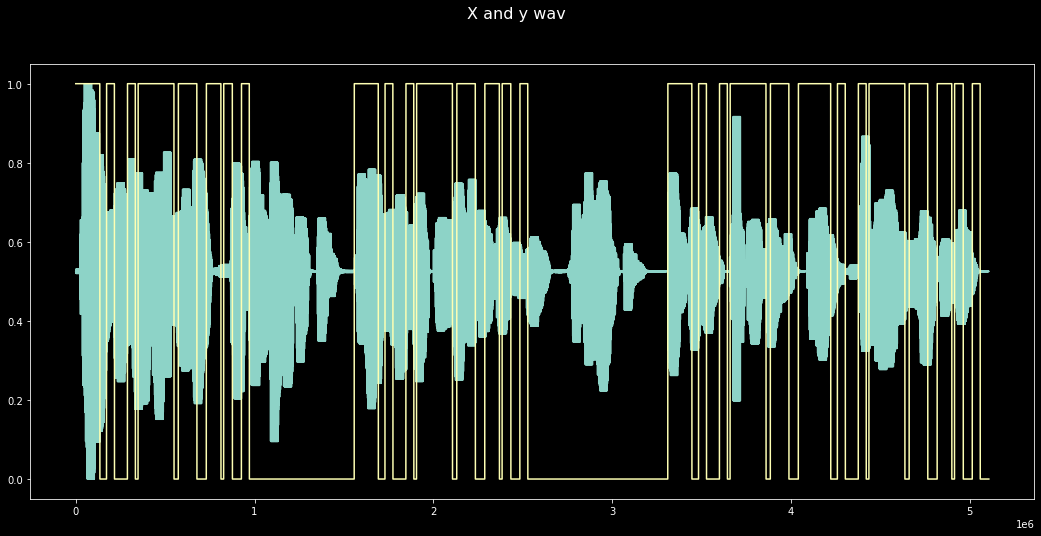

In [151]:
x_ = np.arange(y.shape[0])
print(X.shape)

#
fig, ax1  = plt.subplots(figsize=(18,8))
fig.suptitle('X and y wav', fontsize=16)
# ax1.plot(np.max(X, axis=0))
ax1.plot(np.concatenate(X))
ax1.plot(np.repeat(y, X.shape[1]))
# ax1.scatter(x_, np.concatenate(X), alpha=1)
# ax1.scatter(x_, y-0.5, alpha=0.25)
plt.show()


## CNN Model

In [175]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop





#parameters
kernel_size = 4
# optimizer=RMSprop(lr=1e-4)
optimizer='rmsprop'
strides=16


model = Sequential()
# model.add(layers.Embedding(X.shape[0], kernel_size, input_length=input_length))
model.add(layers.Conv1D(32, kernel_size, activation='relu', strides=strides, input_shape=(seq_length, num_features)))
model.add(layers.AveragePooling1D(24))
model.add(layers.Conv1D(64, kernel_size, activation='relu', strides=strides))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X, y,
                    epochs=10,
                    batch_size=16,
                    validation_split=0.2)

IndexError: index -2315 is out of bounds for axis 1 with size 2206

RNN Model

In [ ]:
# Parameters
timesteps = 8
# optimizer=RMSprop(lr=1e-4)
optimizer='rmsprop'


# Model Input
features = X.shape[1]
input_shape = (timesteps, features)

model = Sequential()
model.add(layers.LSTM(32, input_shape=input_shape, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X, y,
                    epochs=10,
                    batch_size=16,
                    validation_split=0.2)

In [1]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

In [66]:
X_test = X[100:550]
y_test = model.predict_classes(X_test)

print(y_test.reshape(1,-1))

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


In [ ]:



data_files = chunk_char_df['audio'].unique()
sr_ = None
audio_ = None
for wv in data_files:
    fn = f'{wv}'
    print(f'Data file to analyze: {fn}')
    print(f'current sample rate: {sr_}')
    new_audio_, new_sr_ = librosa.load(fn)
    print(f"latest sample rate: {new_sr_}")
    print(f'new_audio_ shape: {new_audio_.shape}')
    if sr_ is None:
        sr_ = new_sr_
    else:
        assert(new_sr_ == sr_)

    if audio_ is None:
        audio_ = new_audio_
    else:
        audio_ = np.concatenate((audio_, new_audio_))
    print('new audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(new_audio_), np.max(new_audio_)))
    print('full audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(audio_), np.max(audio_)))





ap = AudioPrep(sr_, 0.75)
print(ap.size)
_b = ap.resize(audio_)

print(_b.shape)

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,4), tight_layout=True)
fig.suptitle('Waveforms', fontsize=16)
ax1.set_title(f'librosa ({sr_})')
ax1.plot(audio_)

## Event Marker (Boundaries) Dataset
# audio | event_idx



In [ ]:
# boundary_audio
# boundary_idx | audio_data

# boundary_mfcc
# boundry_idx | mfcc_data
